# Modelagem do Problema e Definição da Solução

# Item 1.1. - Modelagem Estatística

Vamos aplicar métodos estatísticos para analisar os dados passados pelo parceiro de projeto.

Isso inclui a exploração de métricas e o uso de modelos estatísticos para avaliar a estratégia de aprendizado por reforço.

Vamos examinar medidas de dispersão, como o desvio padrão, entre os resultados obtidos em diferentes condições e incorporar distribuições estatísticas na formulação de recompensas ou penalidades para o agente, com base na distribuição dos resultados observados.

Especificamente, vamos aplicar métodos estatísticos para termos um _benchmark_ que nos permita avaliar o desempenho de diferentes estratégias de investimento e auxiliar no desenvolvimento de função de recompensa.

## Configurações iniciais

Vamos importar os arquivos e configurar as bibliotecas necessárias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORTANTE: Coloque os arquivos XLS fornecidos pelo parceiro em uma pasta chamada "Data", na raiz do seu Google Drive

purchases_path  = '/content/drive/MyDrive/Data/base2022_compra.xlsb'
sales_path = '/content/drive/MyDrive/Data/base2022_venda.xlsb'

In [ ]:
# Bibliotecas de análise
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Biblioteca para ler arquivos .xlsb
!pip install pyxlsb

## Análise Exploratória Inicial do Dataset

É interessante realizarmos uma análise preliminar do dataset para verificarmos se existe alguma inconsistência ou tratamento necessário.



### Importar as bases de 2022 e converter de xlsb para csv

Escolhemos as bases de 2022 por serem menores. Mesmo assim, o arquivo de compras é bastante extenso para trabalhar (14.2MB, 565320 linhas). Vamos então importar apenas as operações do Cliente 10 (linhas 2 a 17723 do arquivo de compras e linhas 2 a 1233 do arquivo de vendas), para termos uma amostragem.

In [ ]:
# Arquivo de compras - mercado "spot" (à vista)
df_spot = pd.read_excel(purchases_path, engine='pyxlsb', header=0, nrows=17722)
# Arquivo de vendas - mercado de "futures" (a termo)
df_futures = pd.read_excel(sales_path, engine='pyxlsb', header=0, nrows=1232)

### Análise das colunas

#### Planilha Spot (Mercado à Vista):

1. **Cód. Cliente**: Identificação única do cliente que realizou a operação no mercado à vista.
2. **Dt. Operação**: Data em que a operação foi realizada.
3. **Tipo Operação**: Indica se a operação foi uma compra (C) ou venda (V) no mercado spot.
4. **Cód. Título**: Identificação do título (ticker da ação) que foi objeto da operação.
5. **Cód. Corretora**: Identificação da corretora através da qual a operação foi realizada.
6. **Quantidade**: A quantidade do título que foi negociada.
7. **Preço**: O preço unitário pelo qual o título foi negociado.
8. **Valor Líquido**: O valor total da operação, após descontadas as taxas e comissões. É negativo por representar um desembolso de caixa para o BTG.
9. **Dt. Liquidação**: Data em que a operação foi efetivamente liquidada (os títulos e o dinheiro trocaram de mãos).
10. **Tipo**: natureza da operação (AV - À vista).

In [ ]:
print("Colunas: ", df_spot.columns)
print("Número de Linhas: ", df_spot.shape[0])

Colunas:  Index(['Cód. Cliente', 'Dt. Operação', 'Tipo Operação', 'Cód. Título',
       'Cód. Corretora', 'Quantidade', 'Preço', 'Valor Líquido',
       'Dt. Liquidação', 'Tipo'],
      dtype='object')
Número de Linhas:  17722


#### Planilha Futures (Mercado Futuro):

1. **Chave**: Um identificador único para cada operação no mercado futuro.
2. **Cód. Cliente**: Identificação única do cliente que realizou a operação no mercado futuro.
3. **Dt. Operação**: Data em que a operação foi realizada.
4. **Tipo Operação**: Indica se a operação foi uma compra (C) ou venda (V) de um contrato futuro. No caso, estamos lidando apenas com vendas.
5. **Cód. Título**: Identificação do título ou ativo subjacente do contrato futuro.
6. **Cód. Corretora**: Identificação da corretora através da qual a operação foi realizada.
7. **Quantidade**: A quantidade de contratos negociados.
8. **Preço**: O preço unitário pelo qual o contrato foi negociado.
9. **Valor Líquido**: O valor total da operação no mercado futuro, após descontadas as taxas e comissões.
10. **Vencimento**: Data em que o contrato futuro expira.
11. **Tipo**: Tipo de contrato (TE - Termo).
12. **DI**: Taxa de juros DI (Depósito Interbancário) do dia

In [ ]:
print("Colunas: ", df_futures.columns)
print("Número de Linhas: ", df_futures.shape[0])

Colunas:  Index(['Chave', 'Cód. Cliente', 'Dt. Operação', 'Tipo Operação', 'Cód. Título',
       'Cód. Corretora', 'Quantidade', 'Preço', 'Valor Líquido', 'Vencimento',
       'Tipo', 'DI'],
      dtype='object')
Número de Linhas:  1232


### Análise de dados faltantes

Não localizamos dados faltantes nas planilhas. Podemos prosseguir com a análise.

In [ ]:
# Checar por dados faltantes nas bases de dados
missing_values_spot = df_spot.isnull().sum()
missing_values_futures = df_futures.isnull().sum()

print("Valores faltantes no mercado Spot:\n", missing_values_spot)
print("\nValores faltantes no mercado Futures:\n", missing_values_futures)

Valores faltantes no mercado Spot:
 Cód. Cliente      0
Dt. Operação      0
Tipo Operação     0
Cód. Título       0
Cód. Corretora    0
Quantidade        0
Preço             0
Valor Líquido     0
Dt. Liquidação    0
Tipo              0
dtype: int64

Valores faltantes no mercado Futures:
 Chave             0
Cód. Cliente      0
Dt. Operação      0
Tipo Operação     0
Cód. Título       0
Cód. Corretora    0
Quantidade        0
Preço             0
Valor Líquido     0
Vencimento        0
Tipo              0
DI                0
dtype: int64


### Estatísticas Descritivas

In [ ]:
# Estatísticas básicas para o mercado Spot
spot_descriptive_stats = df_spot.describe()
print("\nEstatísticas Descritivas - Mercado Spot:\n", spot_descriptive_stats)

# Estatísticas básicas para o mercado Futures
futures_descriptive_stats = df_futures.describe()
print("\nEstatísticas Descritivas - Mercado Futures:\n", futures_descriptive_stats)


Estatísticas Descritivas - Mercado Spot:
           Quantidade         Preço  Valor Líquido
count   17722.000000  17722.000000   17722.000000
mean     4040.142478     26.645895  -27901.323073
std      7127.213458    102.283707   17829.230406
min         8.000000      0.588843 -101600.672038
25%       694.000000      5.880635  -39973.782848
50%      1706.000000     12.820157  -25946.865265
75%      4088.000000     25.808129  -12906.060401
max    111072.000000   3281.023835    -340.186793

Estatísticas Descritivas - Mercado Futures:
        Dt. Operação     Quantidade        Preço  Valor Líquido    Vencimento  \
count   1232.000000    1232.000000  1232.000000    1232.000000   1232.000000   
mean   44743.471591   26925.289773    29.392634  203025.071938  45003.922890   
std       85.118329   46363.497824   104.500747  120971.599347    169.372766   
min    44594.000000      74.000000     0.629190    3303.225761  44606.000000   
25%    44671.000000    4646.750000     6.403870   97231.97861

### Correlação entre variáveis

In [ ]:
# Correlação no mercado Spot
spot_correlation = df_spot.corr()
print("\nMatriz de Correlação - Mercado Spot:\n", spot_correlation)

# Correlação no mercado Futures
futures_correlation = df_futures.corr()
print("\nMatriz de Correlação - Mercado Futures:\n", futures_correlation)


Matriz de Correlação - Mercado Spot:
                Quantidade     Preço  Valor Líquido
Quantidade       1.000000 -0.109406      -0.421111
Preço           -0.109406  1.000000      -0.008041
Valor Líquido   -0.421111 -0.008041       1.000000

Matriz de Correlação - Mercado Futures:
                Dt. Operação  Quantidade     Preço  Valor Líquido  Vencimento  \
Dt. Operação       1.000000    0.072640 -0.042262       0.057979    0.493617   
Quantidade         0.072640    1.000000 -0.121539       0.405563    0.019790   
Preço             -0.042262   -0.121539  1.000000       0.009349   -0.045233   
Valor Líquido      0.057979    0.405563  0.009349       1.000000   -0.026911   
Vencimento         0.493617    0.019790 -0.045233      -0.026911    1.000000   
DI                 0.708372    0.050324 -0.077662       0.020134    0.454664   

                     DI  
Dt. Operação   0.708372  
Quantidade     0.050324  
Preço         -0.077662  
Valor Líquido  0.020134  
Vencimento     0.454664 

<ipython-input-35-c6e24bf86841>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  spot_correlation = df_spot.corr()
<ipython-input-35-c6e24bf86841>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  futures_correlation = df_futures.corr()


### Visualizações Gráficas


#### Histogramas para o mercado à vista (Spot)


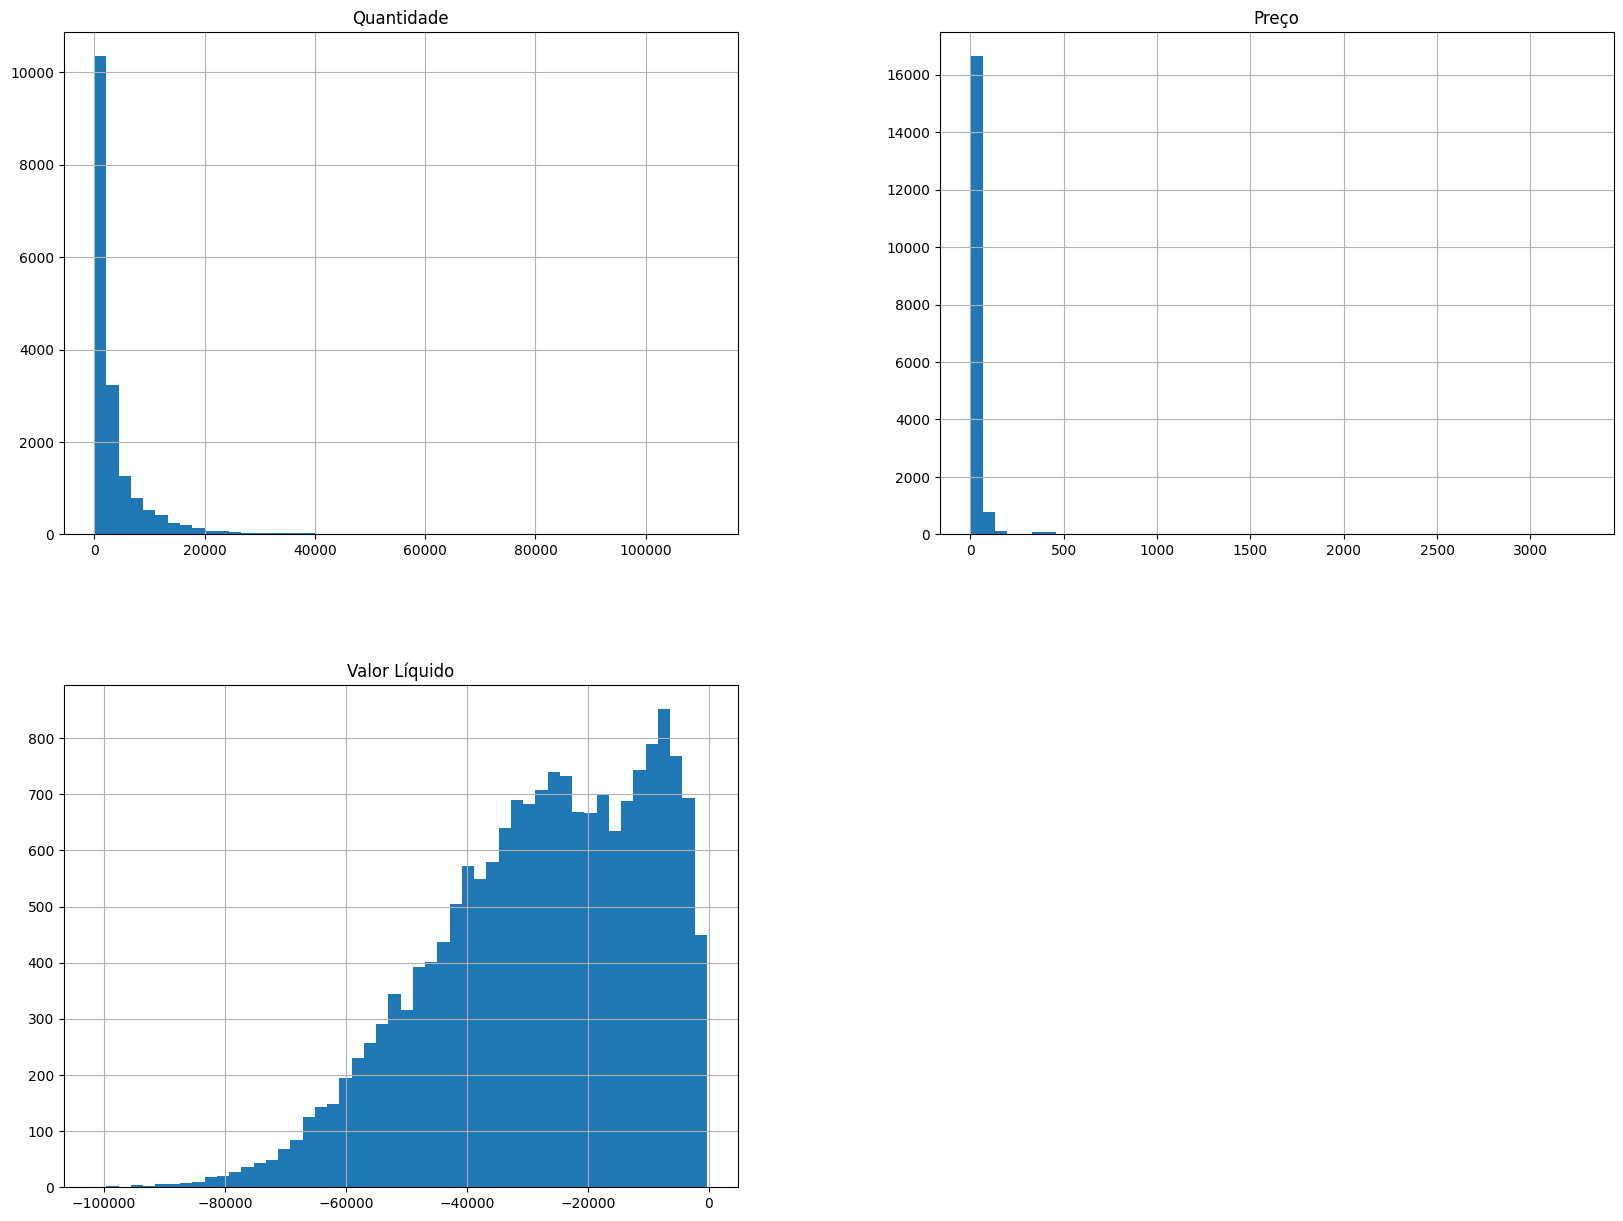

In [ ]:
# Histogramas para o mercado Spot
df_spot.hist(bins=50, figsize=(20,15))
plt.show()

#### Histogramas para o mercado a termo (Futures)

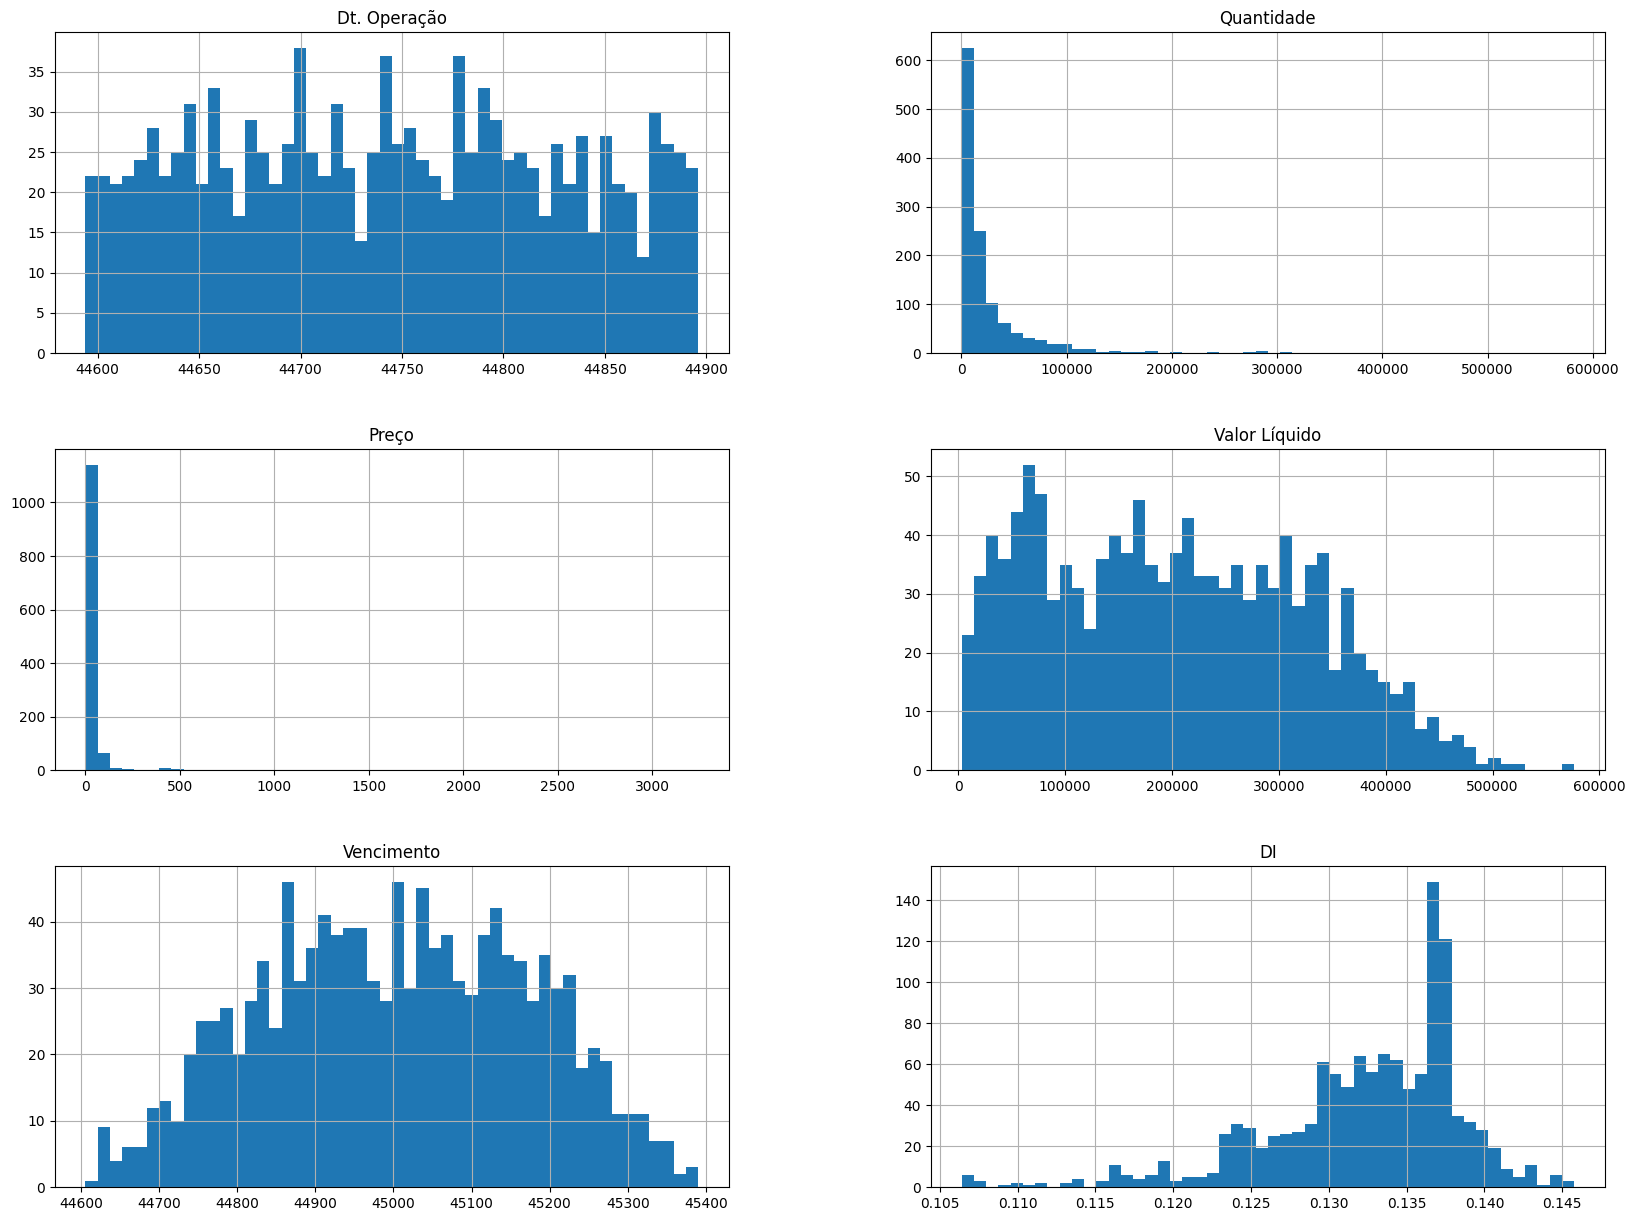

In [ ]:
# Histogramas para o mercado Futures
df_futures.hist(bins=50, figsize=(20,15))
plt.show()

## Exploração de métricas e uso de modelos estatísticos

Para avaliar a estratégia de aprendizado por reforço, foi informado pelo parceiro que era desejável reduzir a variância em relação ao CDI.

Para isso, podemos usar uma função de recompensa que tente encaixar os retornos dentro de uma função densidade de probabilidade (PDF), com a seguinte fórmula:

$$f(x | \mu, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}}​$$

A curva azul abaixo representa a distribuição normal, que é uma função simétrica em torno da média μ, com desvio padrão σ.

### Distribuição normal com assimetria positiva

É possível que a distribuição normal tenha uma assimetria positiva (ou à direita). A fórmula para a função densidade de probabilidade assimétrica (skew normal) é uma adaptação da normal, adicionando o parâmetro de assimetria α. A assimetria é controlada pelo parâmetro α. Quando  α > 0, a cauda da distribuição se estende mais para a direita.

A formulação matemática da função cumulativa de distribuição é a seguinte:

$$f(x)=2\phi \left({\frac {x-\xi }{\omega }}\right)\Phi \left(\alpha \left({\frac {x-\xi }{\omega }}\right)\right)$$

Onde:

- ξ é a localização (que corresponde aproximadamente à média da distribuição, mas não exatamente quando α ≠ 0)
- ω é a escala (semelhante ao desvio padrão, mas não idêntico),
- ϕ(x) é a função densidade de probabilidade (PDF) da distribuição normal padrão (vide acima),
- α é o parâmetro de assimetria
- Φ(x) é a função de distribuição cumulativa da distribuição normal padrão, dada pela fórmula abaixo:

$$\Phi (x)=\int _{-\infty }^{x}\phi (t)\ dt={\frac {1}{2}}\left[1+\operatorname {erf} \left({\frac {x}{\sqrt {2}}}\right)\right]$$


A curva vermelha abaixo representa a distribuição normal com assimetria
(skew) positiva.

### Distribuição normal com assimetria negativa

No caso de uma distribuição normal com assimetria negativa, temos que α < 0. A distribuição se estende mais para a esquerda, indicando a assimetria negativa.

A curva verde abaixo representa a distribuição normal com assimetria
(skew) negativa.


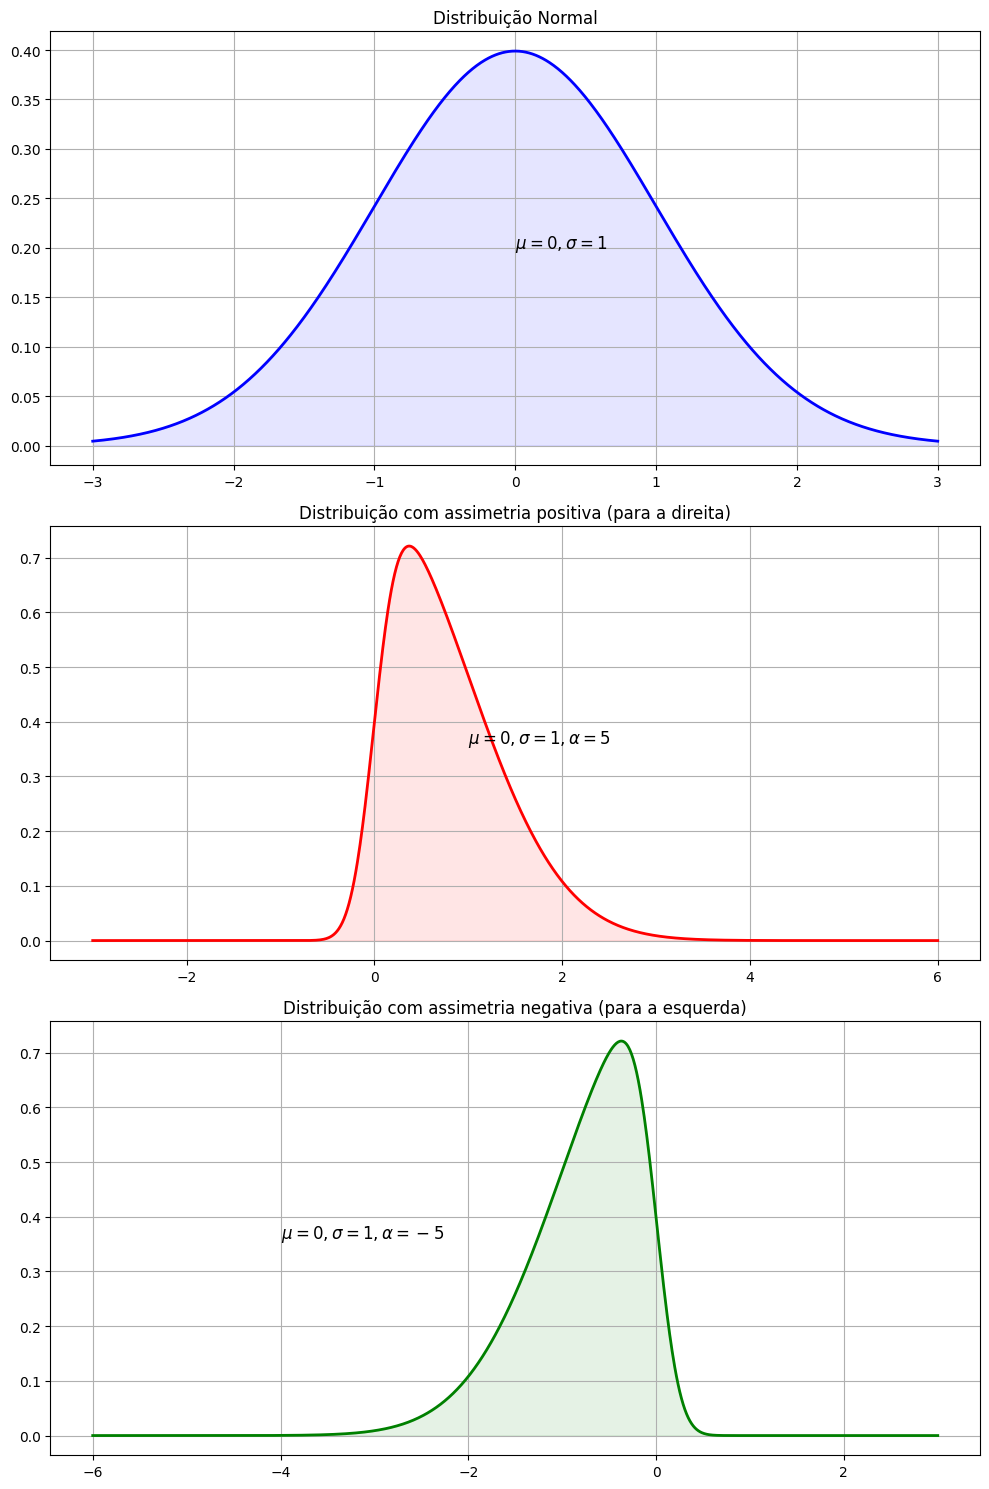

In [ ]:
from scipy.stats import norm, skewnorm

# Parametros
mu = 0  # media
sigma = 1  # desvio padrao

# Distribuicao normal
x_normal = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y_normal = norm.pdf(x_normal, mu, sigma)

# Distribution "a direita"
alpha_right = 5  # Skewness positivo
x_skewed_right = np.linspace(mu - 3*sigma, mu + 6*sigma, 1000)  # Range maior para skew da direita
y_skewed_right = skewnorm.pdf(x_skewed_right, alpha_right, mu, sigma)

# Distribution "a esquerda"
alpha_left = -5  # Skewness negativo
x_skewed_left = np.linspace(mu - 6*sigma, mu + 3*sigma, 1000)  # Range maior para skew da esquerda
y_skewed_left = skewnorm.pdf(x_skewed_left, alpha_left, mu, sigma)

# Criar plot
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Distribuição normal
axs[0].plot(x_normal, y_normal, 'b-', lw=2)
axs[0].set_title('Distribuição Normal')
axs[0].fill_between(x_normal, y_normal, color='blue', alpha=0.1)
axs[0].text(mu, max(y_normal) / 2, f'$\mu={mu}, \sigma={sigma}$', fontsize=12)
axs[0].grid(True)

# Distribuição com Skew para Direita
axs[1].plot(x_skewed_right, y_skewed_right, 'r-', lw=2)
axs[1].set_title('Distribuição com assimetria positiva (para a direita)')
axs[1].fill_between(x_skewed_right, y_skewed_right, color='red', alpha=0.1)
axs[1].text(mu + sigma, max(y_skewed_right) / 2, f'$\mu={mu}, \sigma={sigma}, \\alpha={alpha_right}$', fontsize=12)
axs[1].grid(True)

# Distribuicao com Skew para Esquerda
axs[2].plot(x_skewed_left, y_skewed_left, 'g-', lw=2)
axs[2].set_title('Distribuição com assimetria negativa (para a esquerda)')
axs[2].fill_between(x_skewed_left, y_skewed_left, color='green', alpha=0.1)
axs[2].text(mu - 4*sigma, max(y_skewed_left) / 2, f'$\mu={mu}, \sigma={sigma}, \\alpha={alpha_left}$', fontsize=12)
axs[2].grid(True)

plt.tight_layout()
plt.show()

### Afinal, como essas métricas impactam nossa função de recompensa?

As distribuições estatísticas normais expostas anteriormente podem impactar nossa formulação de recompensas ou penalidades para o agente, com base na distribuição dos resultados observados.

Segundo o TAPI, "_Desejamos achar o conjunto de solução ideal, sendo o conjunto ideal definido como aquele que equaliza, quando possível, a rentabilidade do sintético **em torno de 100% do CDI.**_"

O ideal seria que todos os retornos fossem 100% do CDI, logo nossa função de recompensa valorizará esse valor. Mas e se isso não for possível - o que seria esse "_em torno de_"?

Seria uma distribuição normal padrão, com valores concentrados? Nesse caso teremos uma porcentagem considerável de retornos negativos.

Ou uma com assimetria positiva, para a direita, garantindo que a maior parte dos retornos seria igual ou acima de 100% do CDI? Nesse caso teremos poucos retornos negativos e uma concentração maior de resultados entre 0 e 2 desvios padrões positivos.

Portanto, essas equações podem nos ajudar a embasar a modelagem da função de recompensa nos próximos tópicos e ajudar a esclarecer eventuais pontos de dúvida no futuro, fornecendo um vocabulário compartilhado e métricas de avaliação do retorno esperado.



# Item 1.2. Escolha da Abordagem de Otimização

Nesse tópico, vamos elaborar a estratégia de aprendizado por reforço de forma detalhada.

## Número de agentes

Optamos por adotar apenas um agente para simplificar de forma considerável o processo de aprendizagem e o debug de erros. O agente vai aprender como combinar as posições compradas (long) e vendidas (short) de modo a minimizar a variância dos retornos em relação ao CDI.

Nessa etapa inicial, optamos por modelar um agente, que seria equivalente ao "analista" que seleciona as ações do mercado à vista (spot) e do mercado a termo (futures) que serão combinadas para formar um ativo de renda fixa sintética, com um retorno de "x"% do CDI.


## Representação do Mercado e Restrições

Os dados fornecidos para o modelo já devem estar filtrados adequadamente, de modo que uma ação a termo (_futures_) tenha disponível apenas ações do mercado à vista (_spot_) com o mesmo _cliente_, _corretora_, _código de título_ e com uma _data de liquidação da ação à vista_ que seja _inferior à data de vencimento da ação a termo_. Além disso, não é possível combinar uma quantidade de ações spot superior às ações a termo disponíveis.

## Espaço de Estado

O espaço de estado deve incluir informações relevantes para tomar decisões de negociação, especificamente:

1. Quantidade de ações a termo disponíveis para combinação
2. Preço do termo
3. Taxa DI do dia de negociação do termo
4. Variância atual da porcentagem de retorno em relação a taxa DI do dia *
5. Lista de tuplas com ações à vista (spot) presentemente analisadas e _passíveis de combinação_ (com o filtro mencionado no item anterior aplicado). Essas tuplas terão as seguintes informações:
  - Chave primária sintética
  - Quantidade remanescente disponível para escolha
  - Preço unitário
6. Lista de tuplas com ações à vista (spot) _já selecionadas_ para esse termo. Essas tuplas terão as seguintes informações:
  - Chave primária sintética
  - Quantidade selecionada
  - Preço unitário

\* Esse retorno é dado pela fórmula abaixo:

$$ ((\frac{\text{preco médio compra spot}}{\text{preço venda termo}} - 1) - \text{taxa DI do dia})^2 $$

Sendo preço médio compra spot é a média ponderada das ações já selecionadas, por exemplo: $$p1 \times q1 + p2 \times q2 + p3 \times q3...$$

Todas esses dados são importantes pelo fato de representarem o estado atual de combinações ou um feedback de recompensa (caso da variância da taxa DI)

## Espaço de Ação

O espaço de ação deve permitir que o agente, a partir da ação a termo em análise:

  1. selecione ações à vista (crie combinações);
  2. remova ações à vista selecionadas (remova combinações); ou
  3. mantenha as combinações existentes, caso esteja satisfeito com a taxa DI atual.

## Função de Recompensa

A recompensa é uma função do resultado obtido das combinações, priorizando retornos próximos a 100% da taxa DI.

Contanto, como observado no item 1.1, é necessário ponderar se a função recompensa deve ser ajustada para refletir distribuições com skew. Para simplificar nossa abordagem nesse momento, consideramos apenas a minimização da variância, o que representa recompensar a distribuição normal padrão.

Além disso, no item 1.3., também vamos testar a aplicabilidade de outras funções de recompensa, além das já descritas até o momento.

## Fluxograma

Elaboramos um fluxograma no software _Figma_ que representa visualmente o fluxo de execução do processo descrito anteriormente.

Ele pode ser acessado no seguinte link:

[Fluxograma Figma](https://www.figma.com/file/l0PrcuqM4Yl0M3vhRTArrf/projeto-RF-BTG?type=whiteboard&node-id=0-1)

## Pseudocódigo descrevendo as etapas (steps) e episódios do processo de aprendizado

1. Inicialização:
  - Determinar os hiperparâmetros (tamanho de memória, fator de desconto gamma, taxa de aprendizagem alpha...)
  - Definir o número total de episódios para treinamento.
  - Inicializar o ambiente de mercado e o agente com os parâmetros escolhidos (estado inicial, espaço de ação, etc.).

2. Loop para cada Episódio:
  - Inicializar o estado do ambiente (resetar o ambiente para um estado inicial).
  - Enquanto o episódio não terminar (até que ainda existam ações à vista a serem combinadas):
    1. O agente escolhe uma ação baseada na política atual (selecionar, deselecionar ou manter, baseada no estado atual).
    2. O ambiente executa a ação e retorna o próximo estado, recompensa e se o episódio terminou ou não (quantidade de ações a termo ≠ 0).
    3. O agente atualiza a política de aprendizagem (atualiza a rede Q com base na recompensa e no próximo estado).
    4. Atualizar o estado atual com o próximo estado.

3. Revisão e Ajuste:
   - Após cada episódio, analisar o desempenho do agente (variância do retorno obtido em relaçao ao CDI).
   - Ajustar parâmetros do modelo ou da política de aprendizagem conforme necessário.

4. Teste:
   - Após o treinamento, testar o agente em um conjunto de dados de mercado não visto durante o treinamento para avaliar o desempenho em situações desconhecidas.

5. Implementação:
   - Implementar a estratégia de combinação otimizada em um ambiente de mercado real ou simulado para validar a eficácia da abordagem.



# Item 1.3. Proposta de funções de recompensa

Nesse tópico, vamos detalhar como serão testadas as funções de recompensas e validar essas funções para determinar a melhor opção.

## Implementação de três modelos diferentes de funções de recompensa

A implementação inicial das funções de recompensa será feita de forma forçada e independente, a partir de dados sintéticos, prevendo como a função irá recompensar ou punir uma ação tomada pelo agente. Por enquanto, essa funções estão fora do contexto de treinamento real do agente descrito no tópico anterior.

O objetivo nesse tópico é obter uma completa e diversa análise das funções de recompensa, que provavelmente deverão ser alteradas e adaptadas durante o treinamento para alcançarem melhores resultados.

Nesse contexto, entendemos que podemos trabalhar com três modelos diferentes, que serão descritos adiante.


### Função de recompensa 1: Minimização da variância em relação ao CDI

Esta função calcula a recompensa com base na minimização da variância atual da porcentagem de retorno em relação a taxa DI do dia.

É a função que consideramos nos items anteriores.




In [ ]:
def reward_function_variance(current_state, action, next_state):
    """
    Função que busca reduzir a variância em relação ao CDI.

    :param current_state: Estado atual do ambiente
    :param action: Ação tomada pelo agente
    :param next_state: Estado do ambiente após a ação
    :return: Recompensa numérica
    """
    # Suponha que next_state contém a variância atual da porcentagem de retorno em relação a taxa DI do dia.
    variance = next_state['variance_CDI']
    # A recompensa é o inverso da variância, pois queremos minimizá-la
    reward = -variance
    return reward


### Função de recompensa 2: Maximização do retorno absoluto

Esta função calcula a recompensa com base na maximização do retorno absoluto.

Em uma conversa anterior com o parceiro de negócios, já foi definido que essa função não seria a mais adequada, pois não considera adequadamente o problema de transferência de riqueza entre os cotistas. De qualquer modo, vamos testá-la para comparar e ter como controle.

In [ ]:
def reward_function_return(current_state, action, next_state):
    """
    Esta função calcula a recompensa com base na maximização do retorno absoluto.
    :param current_state: Estado atual do ambiente
    :param action: Ação tomada pelo agente
    :param next_state: Estado do ambiente após a ação
    :return: Recompensa numérica
    """
    # Suponha que next_state contém o retorno absoluto (preço a termo - preço spot)
    absolute_return = next_state['absolute_return']
    # A recompensa é o próprio retorno
    reward = absolute_return
    return reward

### Função de recompensa 3: Retornos acima de 100% do CDI



Essa função calcula a recompensa com base na diferença entre a taxa de retorno e a taxa DI. Como exposto no item 1.1., isso é interessante se quisermos um skew com assimetria positiva.

No entanto, entendemos que não é recomendada a adoção dessa função de recompensa pois ela pode premiar retornos positivos "irreais", como "300%" ou até acima. Como visto, é possível que existam anomalias no cálculo que criem retornos muito acima de 100% do CDI, mas que não são exequíveis na prática.


In [ ]:
def reward_function_above_cdi(current_state, action, next_state):
    """
    Calcula a recompensa com base na diferença entre a taxa de retorno e a taxa DI.
    Recompensa apenas os retornos que são maiores que a taxa DI.

    :param current_state: Estado atual do ambiente
    :param action: Ação tomada pelo agente
    :param next_state: Estado do ambiente após a ação
    :return: Recompensa numérica
    """

    # Suponha que next_state contém a taxa de retorno (preço a termo / preço spot - 1) e a taxa DI
    return_rate = next_state['return_rate']
    DI_rate = next_state['DI_rate']
    # A recompensa é a diferença entre o retorno e a taxa DI, mas apenas se for positiva
    return max(0, return_rate - DI_rate)

## Testando as funções de recompensa


In [ ]:

# Dados simulados para testes
test_states = [
    {'variance_CDI': 0.02, 'absolute_return': 0.05, 'return_rate': 0.06, 'DI_rate': 0.04},
    {'variance_CDI': 0.03, 'absolute_return': -0.01, 'return_rate': 0.02, 'DI_rate': 0.025},
    {'variance_CDI': 0.01, 'absolute_return': 0.03, 'return_rate': 0.01, 'DI_rate': 0.05}
]

# Testando as funções de recompensa
test_results = []
for state in test_states:
    current_state = {}  # Vazio, pois o exemplo não depende do estado atual
    action = None  # Vazio, pois o exemplo não depende da ação
    next_state = state
    rewards = {
        'reward_variance': reward_function_variance(current_state, action, next_state),
        'reward_return': reward_function_return(current_state, action, next_state),
        'reward_above_cdi': reward_function_above_cdi(current_state, action, next_state)
    }
    test_results.append(rewards)

# Convertendo os resultados em DataFrame para facilitar a visualização
pd.DataFrame(test_results)

,reward_variance,reward_return,reward_above_cdi
0,-0.02,0.05,0.02
1,-0.03,-0.01,0.00
2,-0.01,0.03,0.00


# Item 1.4. Testes Iniciais em Código

Os itens anteriores apresentam códigos modularizados para cada um dos tópicos desenvolvidos, bem como demonstram e validam parte dos dados já disponibilizados, com critérios de auditoria de validação bem destacados.

Desse modo, conforme orientado em reunião anterior, esse item encontra-se devidamente preenchido. No entanto, nos propomos a pesquisar outras abordagens de testes que podemos utilizar na solução futuramente, apresentadas a seguir.

1. Simulações de Monte Carlo:
  - Objetivo: Explorar uma ampla gama de cenários de mercado e avaliar a distribuição dos resultados do modelo.
  - Implementação: Realizar simulações de Monte Carlo gerando múltiplas trajetórias de preços de ações e taxas de juros. Para cada trajetória, executar o modelo de aprendizado por reforço e registrar os retornos obtidos.
  - Avaliação: Analisar a distribuição dos retornos em relação ao CDI e verificar se o modelo está conseguindo minimizar a variância e alcançar retornos próximos a 100% do CDI em diferentes cenários.
  - Impacto no Modelo: Este teste ajudará a avaliar a robustez do modelo em diferentes condições de mercado e a ajustar os parâmetros para melhorar o desempenho.

2. Análise de Sensibilidade:
  - Objetivo: Analisar como pequenas variações nos parâmetros de entrada afetam os resultados do modelo.
  - Implementação: Variar sistematicamente os parâmetros do modelo, como a taxa de aprendizagem, o fator de desconto e os hiperparâmetros da função de recompensa. Para cada conjunto de parâmetros, executar o modelo e registrar os retornos obtidos.
  - Avaliação: Observar como as mudanças nos parâmetros afetam a variância dos retornos em relação ao CDI e a proximidade dos retornos a 100% do CDI.
  - Impacto no Modelo: A análise de sensibilidade ajudará a identificar os parâmetros mais críticos para o desempenho do modelo e a otimizá-los para alcançar resultados mais consistentes.

3. Comparação com Benchmarks:
   - Objetivo: Comparar o desempenho do modelo com benchmarks do mercado, como o próprio CDI ou outros índices de referência.
   - Implementação: Executar o modelo e calcular os retornos obtidos. Comparar esses retornos com o CDI e outros benchmarks relevantes para a estratégia de investimento.
   - Avaliação: Avaliar se o modelo está conseguindo superar os benchmarks em termos de retorno ajustado ao risco e consistência dos resultados.
   - Impacto no Modelo: Esta comparação ajudará a contextualizar o desempenho do modelo e a identificar áreas de melhoria.

Considerando a implementação desses testes nas próximas sprints, podemos expandir a validação do modelo e fornecer uma base mais sólida para futuras implementações e otimizações.

